In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

import random
import pickle

In [45]:
## Load training data_set
with open('labels_train.txt') as lf:
    labels = lf.readlines()
labels = [label.strip() for label in labels]

with open('tweets_train.txt') as tf:
    tweets = tf.readlines()
tweets = [json.loads(tweet.strip()) for tweet in tweets]

data = list(zip(tweets, labels))

In [46]:
## EXTRACTING FEATURES FROM TWEETS
tweets = []
all_words_in_tweets = []

stopwords_set = set(stopwords.words("english"))

# Clean up Tweet_text
for tweet, label in data:
    tweet_text = tweet['text']
    words_filtered = [word.lower() for word in tweet_text.split() if len(word) >= 3]
    
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    
    tweets.append((words_without_stopwords, label))
    all_words_in_tweets.extend(words_without_stopwords)

# Get specific word features (IMPORTANT WORDS IN ALL THE TWEETS)
def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features

w_features = get_word_features(all_words_in_tweets)

# Define Features_Function
def features(tweet):
    features = {}
    tweet_text = set(tweet)
    for word in w_features:
        features[f'contains({word})'] = (word in tweet_text)
    return features


In [47]:
## Create Train/Test Datasets
featureset = nltk.classify.apply_features(features, tweets)
# training_set = featureset[1478:]
# testing_set = featureset[:1478]
classifier = nltk.NaiveBayesClassifier.train( featureset )

## Train & Test the accuracy of these features ; Tinker, Rinse, and Repeat until you're happy 
accuracy_per = nltk.classify.accuracy(classifier, featureset) * 100
print(accuracy_per)

80.98782138024357


In [48]:
## Save your classifier to a file
with open('twitter_classifier.pkl', 'wb') as cf:
    pickle.dump(classifier, cf)

In [ ]:
# Load Classfier from 'twitter_classifier.pkl'
with open ('twitter_classifier.pkl', 'rb') as f:
    classifier = pickle.load(f)

# Load tweets from 'tweets.txt'
with open('tweets.txt', 'r') as tf:
    tweets = tf.readlines()
testing_set = [json.loads(tweet.strip()) for tweet in tweets]

# Mark labels
labels = []
for tweet in testing_set:
    labels.append(classifier.classify(features(tweet['text'])))

# Save labels to 'labels.txt'
with open('labels.txt', 'w') as txt_file:
    for label in labels:
        txt_file.write(f"{label}\n")


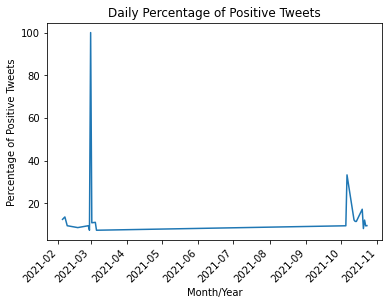

In [50]:
## Convert 'testing_set' into a dataframe -> extract dates of each tweet -> map dates(x-axis) to labels(y-axis).

tweet_time = [(tweet['created_at'], label) for tweet, label in data]
df = pd.DataFrame(tweet_time, columns = ['Date', 'label'])

df = df[(df.label == 'positive') | (df.label == 'negative')]

df['Date'] = pd.to_datetime(df['Date'], format="%a %b %d %X %z %Y")
# total_rows = df['Date'].count()
df['Date'] = df['Date'].dt.date

positive_df = df[df.label == 'positive']

df = df.sort_values(by='Date')
positive_df.sort_values(by='Date', inplace=True)

df['Total_count'] = df.groupby('Date').transform('count')
positive_df['Pos_Count'] = positive_df.groupby('Date').transform('count')

df = df[df.label == 'positive']
df['Pos_Count'] = positive_df['Pos_Count'].values 

df.drop_duplicates(subset='Date', keep='first', inplace=True)
df['Pos_Percent'] = (df.Pos_Count/df.Total_count)*100

plt.plot(df['Date'], df['Pos_Percent'])
plt.title("Daily Percentage of Positive Tweets")
plt.xlabel("Month/Year")
plt.ylabel('Percentage of Positive Tweets')
plt.xticks(rotation=45, ha='right')

plt.savefig("plot.png", dpi=400)